<a href="https://colab.research.google.com/github/natsakh/IAD/blob/main/Pr_5/5_6_MLP_custom_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import random

torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [2]:
# Завантажуємо і нормалізуємо дані(see https://github.com/natsakh/IAD/blob/main/Pr_2/2_3_SVM.ipynb)
wine = load_wine()
X = wine['data']
y = wine['target']

num_input_feat = X.shape[1]
print('num_of_samples: ', X.shape[0])
print('num_input_feat: ', num_input_feat)
print('target_names', wine['target_names'])
num_outputs = len(wine['target_names'])
print('num_outputs', num_outputs)

scaler = StandardScaler()
X = scaler.fit_transform(X)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_of_samples:  178
num_input_feat:  13
target_names ['class_0' 'class_1' 'class_2']
num_outputs 3


In [3]:
# Перетворюємо у тензори
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.long)

In [4]:
# Створюємо TensorDataset
train_data = TensorDataset(X_train, y_train)
test_data  = TensorDataset(X_test, y_test)

# Створюємо DataLoader-и
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

In [5]:
for xb, yb in train_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([32, 13]) torch.Size([32])


In [6]:
# Model: MLP
class WineMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_input_feat, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, num_outputs)   # logits для 3 класів
        )

    def forward(self, x):
        logits = self.net(x)
        return logits

model = WineMLP().to(device)
print(model)

WineMLP(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=3, bias=True)
  )
)


In [7]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.numel())


net.0.weight 832
net.0.bias 64
net.2.weight 2048
net.2.bias 32
net.4.weight 96
net.4.bias 3


In [8]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
n_epochs = 15

In [10]:
# навчання
train_loss_history = []
val_loss_history = []
for epoch in range(n_epochs):

    # --- train ---
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # --- validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()
    val_loss /= len(test_loader)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")


[01] train_loss=1.0816 | val_loss=1.0761
[02] train_loss=1.0254 | val_loss=1.0287
[03] train_loss=0.9676 | val_loss=0.9788
[04] train_loss=0.9175 | val_loss=0.9233
[05] train_loss=0.8548 | val_loss=0.8595
[06] train_loss=0.7964 | val_loss=0.7861
[07] train_loss=0.7148 | val_loss=0.7049
[08] train_loss=0.6309 | val_loss=0.6173
[09] train_loss=0.5490 | val_loss=0.5281
[10] train_loss=0.4684 | val_loss=0.4417
[11] train_loss=0.3978 | val_loss=0.3631
[12] train_loss=0.3233 | val_loss=0.2940
[13] train_loss=0.2814 | val_loss=0.2341
[14] train_loss=0.2278 | val_loss=0.1866
[15] train_loss=0.1882 | val_loss=0.1500


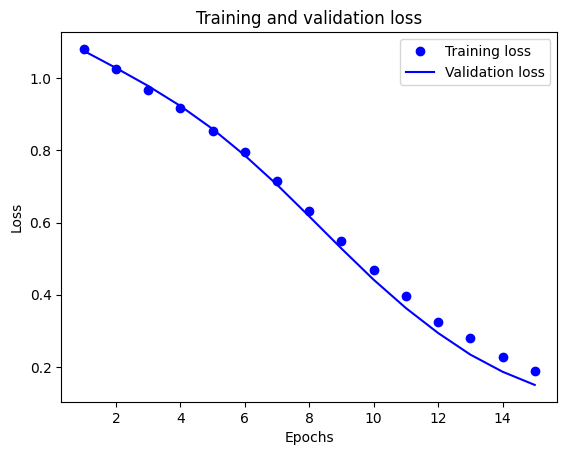

In [11]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)
plt.plot(epochs, train_loss_history, "bo", label="Training loss")
plt.plot(epochs, val_loss_history, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
#test accuracy (just to print once more)
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Final Test Accuracy: {correct/total*100:.2f}%")

Final Test Accuracy: 100.00%
